## Objective:
Determine the 1yr and 7yr survival of prostate cancer patients. Patient survived if they are still still alive after 7years of diagnosis. Patient is counted as dead weather or not the cause of death was due to their cancer. 

Data-set Discription:
‘training_data’ has details of patients, the state of their cancer at time of diagnosis, and some information about the progression of their disease.


## Analysis Road Map
    1.Library Imports
    2.User defined functions
    3.Loading & Data Cleaning
        a.Loading Data
        b.Finding Null Percentage
        c.Removing columns having more than 20 % null
        d.Label Encoding
        e.Mean Computation
        f.Feature Scaling
    4.Model Evaluation
        a. Logestic Regression
        b. Support Vector Machine
        c. Gradient Boosting
        d. Feature Importance
    5.Symptoms Analysis
        a.Important symptoms
    6.Feature Selection
    7.Visuval inferences on important features
        a.Tumor_1_year vs survival_7_years
        b.psa_1_year vs survival_7_years
        c.psa_diagnosis vs survival_7_years
        d.Univariate analysis of numerical columns
        e.ALive and dead with/without symptoms
    8.Final Model Evaluation
        a.Lr model
        b.Gradient Bositing 
        c.Feature Importance plot
    9.Chosing The Best Model
    10. Transform and fit Test Data
        a.Transforming data
        b.Model fitting
        c.Checking training accuracy prediction
        d.Extracting predicted values
    11.Summary
        a. Findings
        b. Why Feature Scaling?
        b. Model selection.
        
Note: In case plots under section 7 are not shown then please manually run the section 1,2 and 7 Graphs are plotted using plotly ofline so you need to run it manually (dependencies are handeled in the code as it is an interactive graph you can hover on it and play with graphs)

# Library Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import plotly.offline as off
from scipy import special
py.offline.init_notebook_mode(connected=True)
from sklearn import preprocessing
from sklearn.decomposition import PCA
le=preprocessing.LabelEncoder()
scaler = preprocessing.StandardScaler()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,precision_score,accuracy_score,roc_curve,auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import plotly.figure_factory as ff

# User Defined Functions

In [ ]:
# Inbuilt Functions
def finding_isnaperct_fun(df):
    total=len(df)
    remove_na=[]
    impute_na=[]
    for i in df.columns:
        if sum(df[i].isna()) > 0:
            perct=(sum(df[i].isna())/total)*100
            #print(i," ",perct)
            if perct>20:
                remove_na.append(i)
            else:
                impute_na.append(i)
    return(remove_na,impute_na)
def checking_ordinality(df):
    ordinal=[]
    for i in df.columns:
        if type(df[i].iloc[0])==str:
            u,p=np.unique(df[i],return_counts=True)
            if len(p)<15:
                ordinal.append(i)
    return(ordinal)
def label_encoder(ordinal,df):
    inverse=[]
    for i in ordinal:
        k=le.fit(df[i])
        df[i]=le.transform(df[i])
        inverse.append(k.inverse_transform(df[i]))
    return(df,inverse)

def plot_bar_interactive(categorical_column,numerical_column,df):
    aggs = ["count","sum","avg","median","mode","rms","stddev","min","max","first","last"]
    agg=[]
    agg_func=[]
    for i,v in enumerate(aggs):
        agg=dict(
            args=['transforms[0].aggregations[0].func', v],
            label=v,
            method='restyle'
        )
        agg_func.append(agg)
    data = [dict(
    type = 'bar',
    x = df[categorical_column],
    y = df[numerical_column],
    mode = 'markers',
    transforms = [dict(
        type = 'aggregate',
        groups = df[categorical_column],
        aggregations = [dict(
        target = 'y', func = 'sum', enabled = True)
        ]
      )]
    )]

    layout = dict(
          title = '<b>Aggregations Plots</b><br>use dropdown to change aggregation',
          xaxis = dict(title = categorical_column),
          yaxis = dict(title = numerical_column),
          updatemenus = [dict(
                x = 0.85,
                y = 1.15,
                xref = 'paper',
                yref = 'paper',
                yanchor = 'top',
                active = 1,
                showactive = False,
                buttons = agg_func
      )]
    )

    off.iplot({'data': data,'layout': layout}, validate=False)

def grouped_hist_ud(lists,labels):
    """
    Creates a group Histogram for the selected columns
    """
# Group data together
    hist_data = lists
    group_labels = labels
    # Create distplot with custom bin_size
    fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
# Plot!
    off.iplot(fig, filename='Distplot with Multiple Datasets')
  

In [62]:
def find_count_symptoms(df,cols,Target):
    """
    It counts the number records under different Symptoms
    """
    symptoms=[]
    alive_with_s_c=[]
    alive_without_s_c=[]
    died_with_s_c=[]
    died_without_s_c=[]
    total_1=len(df[df[Target]==1])
    total_0=len(df[df[Target]==0])
    
    alive = (df[Target]==1)
    dead = (df[Target]==1)
    print(len(alive))
    for i in cols:
        symp = (df[i]==1)
        no_symp = (df[i]==0)
        alive_with_s   = len(df[symp & alive])
        alive_without_s= len(df[no_symp & alive])
        died_with_s    = len(df[symp & dead])
        died_without_s = len(df[no_symp & dead])
        symptoms.append(i)
        alive_with_s_c.append(alive_with_s)
        alive_without_s_c.append(alive_without_s)
        died_with_s_c.append(died_with_s)
        died_without_s_c.append(died_without_s)
    return(symptoms,alive_with_s_c,alive_without_s_c,died_with_s_c,died_without_s_c)

def alive_and_died_with_symp(symp,alive_w_s,died_w_s):
    """
    Plots an intractive chart with data from Alive/died WITH different symptoms metric 
    """
    fig = {
    "data": [
    {
    "values": alive_w_s,
    "labels": symp
    ,
    "domain": {"x": [0, .48]},
    "name": "Alive with Symptoms",
    "hoverinfo":"label+percent+name",
    "hole": .4,
    "type": "pie"
    },
    {
    "values": died_w_s,
    "labels": symp,
    #"text":["CO2"],
    "textposition":"inside",
    "domain": {"x": [.52, 1]},
    "name": "dead with symptoms",
    "hoverinfo":"label+percent+name",
    "hole": .4,
    "type": "pie"
    }],
    "layout": {
    "title":"Alive and Died Whith symptoms",
    "annotations": [
        {
            "font": {
                "size": 20
            },
            "showarrow": False,
            "text": "AWS",
            "x": 0.20,
            "y": 0.5
        },
        {
            "font": {
                "size": 20
            },
            "showarrow": False,
            "text": "DWS",
            "x": 0.8,
            "y": 0.5
        }
    ]
    }
    }
    off.iplot(fig, filename='donut')
    
def alive_and_died_without_symp(symp,alive_w_o_s,died_w_o_s):
    """
    Plots an intractive chart with data from Alive/died WITHOUT different symptoms metric 
    """
    fig = {
    "data": [
    {
    "values": alive_w_o_s,
    "labels": symp
    ,
    "domain": {"x": [0, .48]},
    "name": "Alive without Symptoms",
    "hoverinfo":"label+percent+name",
    "hole": .4,
    "type": "pie"
    },
    {
    "values": died_w_o_s,
    "labels": symp,
    #"text":["CO2"],
    "textposition":"inside",
    "domain": {"x": [.52, 1]},
    "name": "dead without symptoms",
    "hoverinfo":"label+percent+name",
    "hole": .4,
    "type": "pie"
    }],
    "layout": {
    "title":"Alive and Died Whithout symptoms",
    "annotations": [
        {
            "font": {
                "size": 20
            },
            "showarrow": False,
            "text": "AW-OS",
            "x": 0.20,
            "y": 0.5
        },
        {
            "font": {
                "size": 20
            },
            "showarrow": False,
            "text": "DW-OS",
            "x": 0.8,
            "y": 0.5
        }
    ]
    }
    }
    off.iplot(fig, filename='donut')

# Loading & Data Cleaning
    1.Loading Data
    2.Finding Null Percentage
    3.Removing columns having more than 20 % null
    4.Label Encoding
    5.Mean Computation
    6.Feature Scaling

In [4]:
df = pd.read_csv("training_data.csv")
# checking null percentage in the data frame.
remove_na,impute_na=finding_isnaperct_fun(df)
#Removing column from df.
df.drop(remove_na,axis=1,inplace=True)
# Label encoding starts...
object_col= df.dtypes[df.dtypes == 'object'].keys()
numeric_col=df.dtypes[df.dtypes != 'object'].keys()
special_handeling=[v for i,v in enumerate(object_col) 
                   if v=='diagnosis_date' or v=="symptoms"]
object_col=[v for i,v in enumerate(object_col) if v not in special_handeling]
df,inverse=label_encoder(object_col,df)
#later_handeling=df[special_handeling]
#df.drop(special_handeling,axis=1,inplace=True)
# Mean Computation starts
remove_na,impute_na=finding_isnaperct_fun(df)
impute_na=impute_na[:-1]
df[impute_na]=df[impute_na].fillna(df.mean())
ch=df['symptoms'].str.get_dummies(sep=',')
for i in ch.columns:
    df[i]=ch[i]
df.drop(["symptoms","diagnosis_date","id","race"],axis=1,inplace=True)
#df["change_tu_size"]=df['tumor_1_year']-df['tumor_diagnosis']
#df["change_psa_size"]=df['psa_1_year']-df['psa_diagnosis']

In [5]:
# train test split-------------------------------------------
features=[v for i,v in enumerate(df.columns) 
          if v!= 'survival_7_years' and v!= 'survival_1_year' ]
y=df['survival_7_years']
X=df[features]
X_symptoms=df[features[-16:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, random_state=42)
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_symptoms, 
                                                            y, test_size=0.30, 
                                                            random_state=42)
#----Scalling the data before proceding..-------------------------
scaler.fit(X_train)
X_train_tr = scaler.transform(X_train)
X_test_tr  = scaler.transform(X_test)

In [6]:
df[features[-16:]]

O01  O08  O09  O10  O11  P01  P02  P03  S04  S07  S10  U01  U02  U03  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    1   
1        0    0    0    0    0    0    0    0    0    1    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    1    1    1    1   
3        0    0    0    0    1    0    0    0    0    0    1    1    1    0   
4        0    0    0    0    0    0    0    0    0    1    0    1    0    1   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
15380    0    0    0    0    0    0    0    0    0    1    0    0    0    1   
15381    0    0    0    0    1    0    0    0    0    1    0    0    1    0   
15382    0    0    0    0    0    0    0    0    0    0    0    1    0    1   
15383    0    0    0    0    0    1    0    0    1    0    0    0    0    0   
15384    0    0    0    0    0    0    0    0    0    0    0    1    0    0   

       U05  U06  
0        0    0  
1        0    1  
2        0    0  
3        0    0  
4        1    0  
...    ...  ...  
15380    0    0  
15381    0    0  
15382    0    0  
15383    0    0  
15384    0    0  

[15385 rows x 16 columns]

# Model Execution
    a. Logestic Regression
    b. Support Vector Machine
    c. Gradient Boosting
    d. Feature Importance

## Logestic Regression 

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      6074
           1       0.61      0.47      0.53      4695

    accuracy                           0.64     10769
   macro avg       0.63      0.62      0.62     10769
weighted avg       0.63      0.64      0.63     10769

              precision    recall  f1-score   support

           0       0.66      0.76      0.71      2660
           1       0.59      0.47      0.52      1956

    accuracy                           0.64      4616
   macro avg       0.63      0.62      0.62      4616
weighted avg       0.63      0.64      0.63      4616



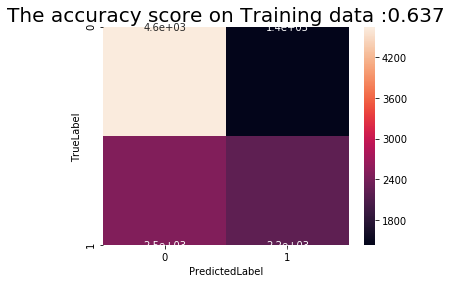

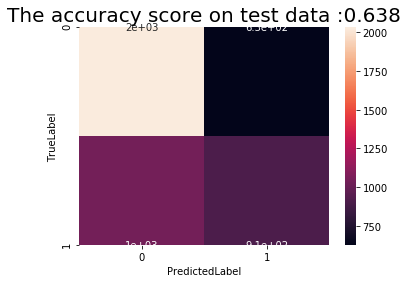

In [9]:
Lr = LogisticRegression(random_state=0, solver='lbfgs')
Lr.fit(X_train_tr,y_train)
pred=Lr.predict(X_train_tr)
cm = confusion_matrix(y_train,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.5,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on Training data :{0:.3f}'
          .format(accuracy_score(y_train,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_train,pred))
pred=Lr.predict(X_test_tr)
cm = confusion_matrix(y_test,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.6,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on test data :{0:.3f}'
          .format(accuracy_score(y_test,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_test,pred))

## Support Vector 

In [15]:
svm = SVC(kernel='rbf')
parameters = {'C':[1, 0.25],'gamma': [0.01, 0.1]}
clf = GridSearchCV(svm, parameters,cv=10)
clf.fit(X_train_tr,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 0.25], 'gamma': [0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [16]:
clf.cv_results_

{'mean_fit_time': array([7.58283026, 7.97400784, 6.15304153, 7.41656337]),
 'std_fit_time': array([1.03835335, 0.3918772 , 0.46856396, 1.29108592]),
 'mean_score_time': array([0.42437799, 0.44643214, 0.38791051, 0.48568211]),
 'std_score_time': array([0.09929844, 0.00844201, 0.01762624, 0.0937449 ]),
 'param_C': masked_array(data=[1, 1, 0.25, 0.25],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.01, 0.1, 0.01, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'gamma': 0.01},
  {'C': 1, 'gamma': 0.1},
  {'C': 0.25, 'gamma': 0.01},
  {'C': 0.25, 'gamma': 0.1}],
 'split0_test_score': array([0.64100186, 0.62894249, 0.63543599, 0.6038961 ]),
 'split1_test_score': array([0.63172542, 0.61131725, 0.62615955, 0.59554731]),
 'split2_test_score': array([0.64378479, 0.63636364, 0.63543599, 0.59647495]),
 'split3_test_score': array(

              precision    recall  f1-score   support

           0       0.68      0.80      0.73      6074
           1       0.66      0.51      0.58      4695

    accuracy                           0.67     10769
   macro avg       0.67      0.65      0.65     10769
weighted avg       0.67      0.67      0.66     10769

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      2660
           1       0.62      0.48      0.54      1956

    accuracy                           0.66      4616
   macro avg       0.65      0.63      0.63      4616
weighted avg       0.65      0.66      0.65      4616



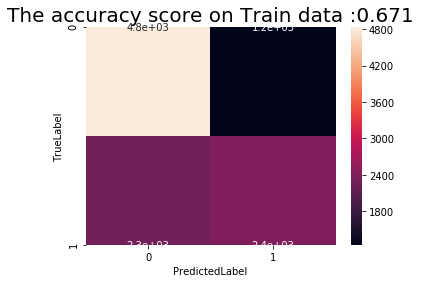

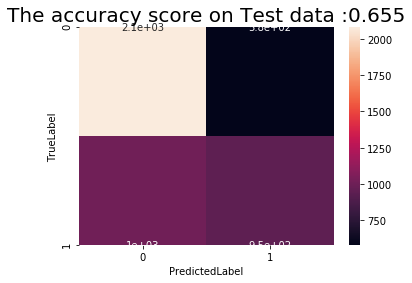

In [14]:
model_svm=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model_svm.fit(X_train_tr,y_train)
pred=model_svm.predict(X_train_tr)
cm = confusion_matrix(y_train,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.6,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on Train data :{0:.3f}'
          .format(accuracy_score(y_train,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_train,pred))
#--test data
pred=model_svm.predict(X_test_tr)
cm = confusion_matrix(y_test,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.7,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on Test data :{0:.3f}'
          .format(accuracy_score(y_test,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_test,pred))

## Gradient bosting

In [11]:
learning_rates = [0.005, 0.05, 0.1, 0.25, 0.5, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=2000, learning_rate = learning_rate, 
                                    max_features='auto', random_state = 0)
    gb.fit(X_train_tr, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_tr, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test_tr, y_test)))
    print()

Learning rate:  0.005
Accuracy score (training): 0.701
Accuracy score (validation): 0.672

Learning rate:  0.05
Accuracy score (training): 0.817
Accuracy score (validation): 0.662

Learning rate:  0.1
Accuracy score (training): 0.883
Accuracy score (validation): 0.658

Learning rate:  0.25
Accuracy score (training): 0.970
Accuracy score (validation): 0.639

Learning rate:  0.5
Accuracy score (training): 0.999
Accuracy score (validation): 0.641

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.629



              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2660
           1       0.61      0.61      0.61      1956

    accuracy                           0.67      4616
   macro avg       0.66      0.66      0.66      4616
weighted avg       0.67      0.67      0.67      4616

Area under ROC curve = 0.74


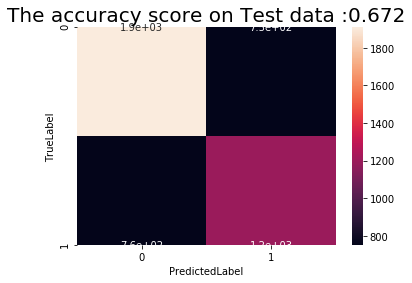

In [12]:
gb = GradientBoostingClassifier(n_estimators=2000, learning_rate = 0.005, 
                                max_features="auto", random_state = 0)
gb.fit(X_train_tr, y_train)
pred = gb.predict(X_test_tr)
cm = confusion_matrix(y_test,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.8,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on Test data :{0:.3f}'.format(accuracy_score(y_test,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_test,pred))
y_scores_gb = gb.decision_function(X_test_tr)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

## Feature Importance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

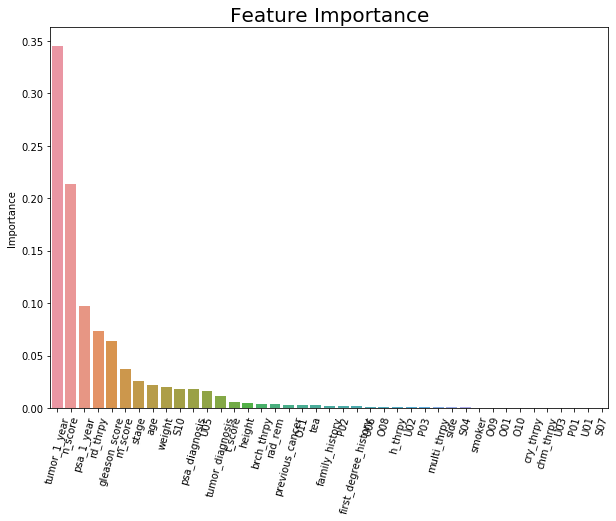

In [13]:
imp = pd.DataFrame(gb.feature_importances_ ,columns = ['Importance'],
                   index = X_train.columns)
imp = imp.sort_values(['Importance'], ascending = False)
plt.figure(figsize=(10,7))
sns.barplot(x=imp.index,y=imp["Importance"])
plt.title("Feature Importance",fontsize=20, ha='center')
plt.xticks(rotation=75)

>The top feature contenders are: 
- Tumor Size in 1 year after Diagnosis (in mm): tumor_1_year
- Wheather cancer has spread to lymph nodes: n_score
- Level of prostate-specific antigen in blood 1 year after diagnosis, in ng/mL: psa_1_year

# Symptom Analysis. 

Using all the features supresses the importance of Symptoms the patient was showing. I wanted to review the just symptoms using gradient bosting method.


## Important Symptoms

In [18]:
# Gradient Boosting on Symptom.
learning_rates = [0.005, 0.05, 0.1, 0.25, 0.5, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=2000, learning_rate = learning_rate, max_features='auto', random_state = 0)
    gb.fit(X_train_S, y_train_S)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_S, y_train_S)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test_S, y_test_S)),'\n')

Learning rate:  0.005
Accuracy score (training): 0.568
Accuracy score (validation): 0.561 

Learning rate:  0.05
Accuracy score (training): 0.578
Accuracy score (validation): 0.553 

Learning rate:  0.1
Accuracy score (training): 0.583
Accuracy score (validation): 0.550 

Learning rate:  0.25
Accuracy score (training): 0.584
Accuracy score (validation): 0.543 

Learning rate:  0.5
Accuracy score (training): 0.584
Accuracy score (validation): 0.542 

Learning rate:  1
Accuracy score (training): 0.584
Accuracy score (validation): 0.543 



              precision    recall  f1-score   support

           0       0.58      0.90      0.70      2660
           1       0.43      0.10      0.17      1956

    accuracy                           0.56      4616
   macro avg       0.50      0.50      0.43      4616
weighted avg       0.51      0.56      0.47      4616

Area under ROC curve = 0.56


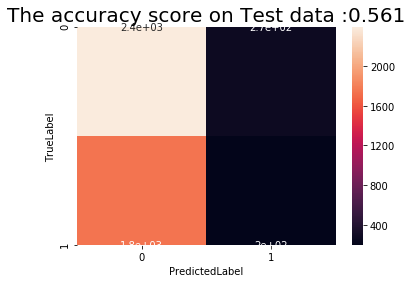

In [19]:
gb = GradientBoostingClassifier(n_estimators=2000, learning_rate = 0.005, max_features="auto", random_state = 0)
gb.fit(X_train_S, y_train_S)
pred = gb.predict(X_test_S)
cm = confusion_matrix(y_test_S,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.8,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on Test data :{0:.3f}'.format(accuracy_score(y_test_S,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_test_S,pred))
y_scores_gb = gb.decision_function(X_test_S)
fpr_gb, tpr_gb, _ = roc_curve(y_test_S, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

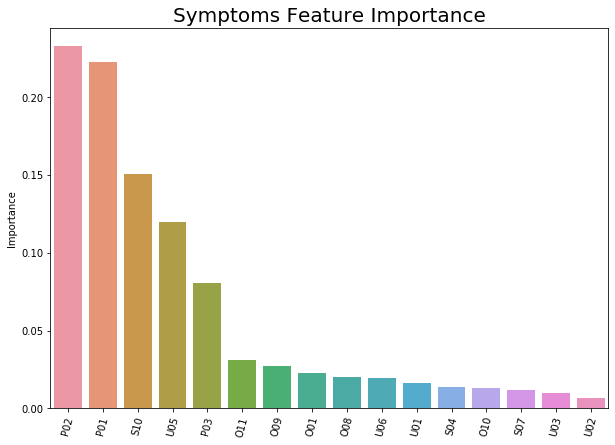

In [20]:
imp_s = pd.DataFrame(gb.feature_importances_ ,columns = ['Importance'],index = X_train_S.columns)
imp_s = imp_s.sort_values(['Importance'], ascending = False)
plt.figure(figsize=(10,7))
sns.barplot(x=imp_s.index,y=imp_s["Importance"])
plt.title("Symptoms Feature Importance",fontsize=20, ha='center')
plt.xticks(rotation=75)

>The top symptom contenders are: 
- P02
- P01
- S10
- U05

Note: even though we don't know what the codes are, we can rate the symptom codes

# Feature Selection 

In [21]:
important_features= list(imp_s.index[:6])+ list(imp.index[:11])
y=df['survival_7_years']
X=df[important_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler.fit(X_train)
X_train_tr = scaler.transform(X_train)
X_test_tr  = scaler.transform(X_test)

# Visuval inferences on important features
    a.Tumor_1_year vs survival_7_years
    b.psa_1_year vs survival_7_years
    c.psa_diagnosis vs survival_7_years
    d.Univariate analysis of numerical columns
    e.ALive and dead with/without symptoms

## Tumor_1_year vs survival_7_years

In [24]:
finaldf = df[important_features]
finaldf['Target'] = df['survival_7_years']
finaldf.head()

P02  P01  S10  U05  P03  O11  tumor_1_year  n_score  psa_1_year  rd_thrpy  \
0    0    0    0    0    0    0     39.000000        0    4.200000         0   
1    0    0    0    0    0    0     16.000000        1    7.500000         1   
2    0    0    1    0    0    0     89.000000        0   18.500000         1   
3    0    0    1    0    0    1     38.251998        0    9.116809         0   
4    0    0    0    1    0    0     87.000000        0    9.116809         1   

   gleason_score  m_score  stage   age      weight  S10  psa_diagnosis  Target  
0            4.0        0      0  86.0  158.000000    0       8.700000       0  
1            8.0        0      4  66.0  174.000000    0      13.700000       0  
2            9.0        0      2  84.0  176.800043    1      16.000000       1  
3            8.0        0      2  86.0  173.000000    1      11.700894       0  
4            8.0        0      4  78.0  201.000000    0      18.100000       0

In [25]:
#1.Tumor_1_year vs survival_7_years
plot_bar_interactive("Target","tumor_1_year",finaldf)

## psa_1_year vs survival_7_years

In [26]:
#psa_1_year vs survival_7_years
plot_bar_interactive("Target","psa_1_year",finaldf)

## psa_diagnosis vs survival_7_years

In [27]:
plot_bar_interactive("Target","psa_diagnosis",finaldf)

## age vs survival_7_years

In [28]:
plot_bar_interactive("Target","age",finaldf)

## Univariate analysis of numerical column

In [29]:
labels=["tumor_1_year","psa_1_year","age","psa_diagnosis"]
lists=[finaldf["tumor_1_year"],finaldf["psa_1_year"],finaldf["age"],finaldf["psa_diagnosis"]]
grouped_hist_ud(lists,labels)

## Alive and dead with/without symptom

In [33]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15385 entries, 0 to 15384
Data columns (total 18 columns):
P02              15385 non-null int64
P01              15385 non-null int64
S10              15385 non-null int64
U05              15385 non-null int64
P03              15385 non-null int64
O11              15385 non-null int64
tumor_1_year     15385 non-null float64
n_score          15385 non-null int64
psa_1_year       15385 non-null float64
rd_thrpy         15385 non-null int64
gleason_score    15385 non-null float64
m_score          15385 non-null int64
stage            15385 non-null int64
age              15385 non-null float64
weight           15385 non-null float64
S10              15385 non-null int64
psa_diagnosis    15385 non-null float64
Target           15385 non-null int64
dtypes: float64(6), int64(12)
memory usage: 2.1 MB


In [41]:
list(imp_s.index[:6])

['P02', 'P01', 'S10', 'U05', 'P03', 'O11']

In [63]:
cols=list(imp_s.index[:6])
symp, alive_w_s, alive_w_o_s, died_w_s, died_w_o_s = find_count_symptoms(finaldf,
                                                                         cols, "Target")
alive_and_died_with_symp(symp, alive_w_s, died_w_s)
alive_and_died_without_symp(symp, alive_w_o_s, died_w_o_s)

15385


TypeError: '<' not supported between instances of 'str' and 'int'

# Final Model Evaluation
    1.Lr model
    2.Gradient Bositing 
    3.Feature Importance plot

## Lr model

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      6074
           1       0.60      0.46      0.52      4695

    accuracy                           0.63     10769
   macro avg       0.62      0.61      0.61     10769
weighted avg       0.63      0.63      0.62     10769

              precision    recall  f1-score   support

           0       0.66      0.76      0.70      2660
           1       0.58      0.46      0.51      1956

    accuracy                           0.63      4616
   macro avg       0.62      0.61      0.61      4616
weighted avg       0.62      0.63      0.62      4616



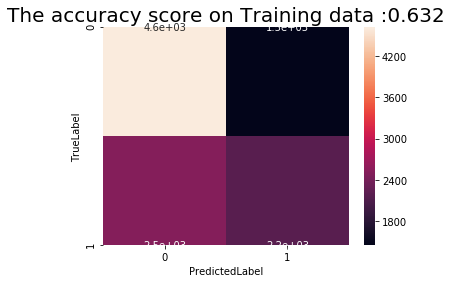

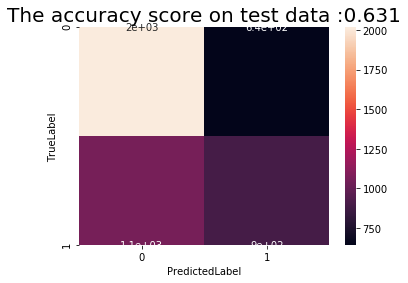

In [35]:
Lr = LogisticRegression(random_state=0, solver='lbfgs')
Lr.fit(X_train_tr,y_train)
pred=Lr.predict(X_train_tr)
cm = confusion_matrix(y_train,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.5,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on Training data :{0:.3f}'.format(accuracy_score(y_train,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_train,pred))
pred=Lr.predict(X_test_tr)
cm = confusion_matrix(y_test,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.6,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on test data :{0:.3f}'.format(accuracy_score(y_test,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_test,pred))

## Gradient boosting

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      2660
           1       0.61      0.62      0.62      1956

    accuracy                           0.67      4616
   macro avg       0.67      0.67      0.67      4616
weighted avg       0.67      0.67      0.67      4616

Area under ROC curve = 0.74


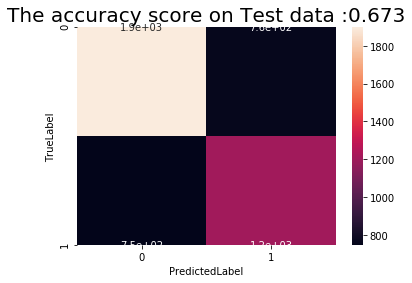

In [37]:
gb = GradientBoostingClassifier(n_estimators=2000, learning_rate = 0.005, max_features="auto", random_state = 0)
gb.fit(X_train_tr, y_train)
pred = gb.predict(X_test_tr)
cm = confusion_matrix(y_test,pred)
dat_framecm = pd.DataFrame(cm)
plt.figure(figsize=(5.8,4))
sns.heatmap(dat_framecm,annot=True)
plt.title('The accuracy score on Test data :{0:.3f}'
          .format(accuracy_score(y_test,pred)),fontsize=20, ha='center')
plt.ylabel('TrueLabel')
plt.xlabel('PredictedLabel')
print(classification_report(y_test,pred))
y_scores_gb = gb.decision_function(X_test_tr)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

## Feature Importance plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

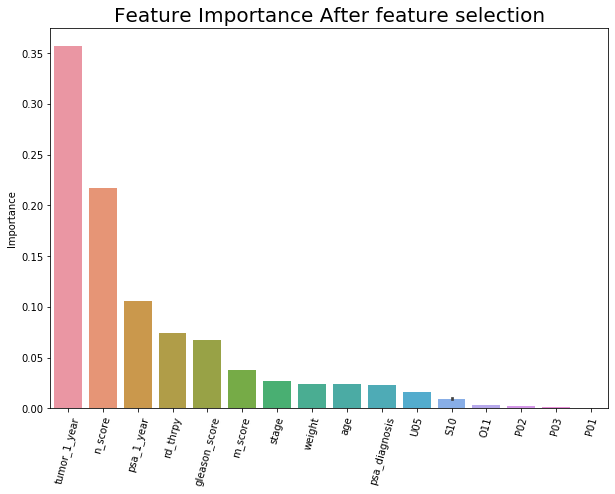

In [38]:
imp = pd.DataFrame(gb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
imp = imp.sort_values(['Importance'], ascending = False)
plt.figure(figsize=(10,7))
sns.barplot(x=imp.index,y=imp["Importance"])
plt.title("Feature Importance After feature selection",fontsize=20, ha='center')
plt.xticks(rotation=75)

# Chosing The Best Model

In [39]:
number_of_models=["LR-Base","SVM-Base","GB-Base","LR-final-model","GB-final-model"]
test_Accurac=[63.8,65.5,67.2,63.1,67.3]
fig = {
    "data": [
    {
    "values": test_Accurac,
    "labels": number_of_models
    ,
    "domain": {"x": [0, .48]},
    "name": "CV Accuracy",
    "hoverinfo":"label+percent+name",
    "hole": .4,
    "type": "pie"
    }],
    "layout": {
    "title":"Models vs CV_acuracy",
    "annotations": [
        {
            "font": {
                "size": 20
            },
            "showarrow": False,
            "text": "Acc",
            "x": 0.20,
            "y": 0.5
        }
    ]
    }
    }
off.iplot(fig, filename='donut')

>Best Models is Gradient Bosting_Final model

# Summary
        a. Findings
        b. Why Feature Scaling?
        c. Model selection.


## Findings

>1. If the Size of primary tumor 1 year after diagnosis is greator than 33.23 mm then chances are higher that he or she will die.
2. If Level of prostate-specific antigen in blood 1 year after diagnosis, is greator than 8.48 ng/mL then chances of survival is less.
3. While analyzing symptoms I found that death percentage increases if people are having "S01,P01,P02 and P03". (Where  as chances of survival is more if the person is having O11 as a symptom.) still have to verify

## Why Feature Scaling?
Scaling was of prime importance as many features were not same measure for example hieght and weight were in different scale compared to psa_1_year or rd_thrpy and many more. So befor giving the model to machine learning algorithims data preprocessing was needed.


## Model selection

Part 1

1. Before selecting the model i had to do feature transformation. This was needed because symptoms columns were grouped together and for model to have an higher accuracy symptoms columns needed to be transformed via creating dummy variables.

2. Logestic Regression : Started with the simple model found that the model was not prforming well on both test and training data. That meant model was suffering from high bias. To solve this issue i swithed to more complex non linear model.

3. Support Vector Machine : I used various C and gamma values in rbf kernal with 10 fold cross validation to find the best model. But still the increase in Test accuracy was not significant.

4. Finally I tried ensemble families with different learning rate. I found that the training error was significantly decreased and the accuracy was increase compared to Logestic regression model. Most importantly Area under the graph of ROC curve was decent that of 0.74 out of 1.

Part 2

1. As the data challenge gave more importance to accuracy i subseted the symptoms into another dataframe and plotted the importance of symptoms on survival rate.

2. Then I did my feature selection using the above informations and passed them to the model, but unfortunately the new model still had the same accuracy.  

3. So finally I selected the model with less features as it was performing the same compared to the model having all features plus the final features showed more than 95% variance in predicting the dependent variable. 
